In [1]:
import os
import sys
#path environment
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")
import traci

import xml.etree.ElementTree as ET

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
import numpy as np

In [2]:
file_output = "my_output_file_grid_min.xml"

sumo_cmd = ['sumo', 
            '--duration-log.statistics', 
            '--tripinfo-output', file_output, 
            '-c', 'maps/grid/grid.sumo.cfg']

In [3]:
def reroute_vehicle(vehicle_id):
    # Get the vehicle's current edge
    current_edge = traci.vehicle.getRoadID(vehicle_id)

    # Get the current route
    current_route = traci.vehicle.getRoute(vehicle_id)

    # Initialize variables for best route selection
    best_route = current_route
    min_time_loss = float('inf')

    # Iterate over the current route to find alternative edges
    for edge in current_route:
        try:
            # Get the travel time for the edge
            edge_travel_time = traci.edge.getTraveltime(edge)

            # Compare to find the edge with the minimum travel time
            if edge_travel_time < min_time_loss:
                min_time_loss = edge_travel_time
                best_route = current_route
        except traci.exceptions.TraCIException:
            continue

    # Set the new route if it's different and has less time loss
    if best_route != current_route:
        traci.vehicle.setRoute(vehicle_id, best_route)



def analyze_time_loss(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Initialize variables for analysis
    total_time_loss = 0.0
    total_waiting_time = 0.0
    total_duration = 0.0
    total_reroutes = 0
    vehicle_count = 0

    # Iterate over each tripinfo element in the XML
    for trip in root.findall('tripinfo'):
        time_loss = float(trip.get('timeLoss'))
        waiting_time = float(trip.get('waitingTime'))
        duration = float(trip.get('duration'))
        reroutes = int(trip.get('rerouteNo'))
        
        total_time_loss += time_loss
        total_waiting_time += waiting_time
        total_duration += duration
        total_reroutes += reroutes
        vehicle_count += 1

    # Calculate averages
    average_time_loss = total_time_loss / vehicle_count if vehicle_count > 0 else 0
    average_waiting_time = total_waiting_time / vehicle_count if vehicle_count > 0 else 0
    average_duration = total_duration / vehicle_count if vehicle_count > 0 else 0
    average_reroutes = total_reroutes / vehicle_count if vehicle_count > 0 else 0

    # Store results in a dictionary
    results = {
        'Total Vehicles': vehicle_count,
        'Total Time Loss': total_time_loss,
        'Average Time Loss': average_time_loss,
        'Total Waiting Time': total_waiting_time,
        'Average Waiting Time': average_waiting_time,
        'Average Duration': average_duration,
        'Total Reroutes': total_reroutes,
        'Average Reroutes': average_reroutes
    }
    return results


In [4]:
reroute_intervals = [5, 30, 60, 120]  # Different intervals to test
STEPTOTAL = 3600
simulation_results = []

for reroute_interval in reroute_intervals:
    print(f"Running simulation with reroute interval: {reroute_interval} seconds")
    
    # Start SUMO
    traci.start(sumo_cmd)

    step = 0
    try:
        while step < STEPTOTAL:
            traci.simulationStep()
    
            if step % reroute_interval == 0:
                for vehicle_id in traci.vehicle.getIDList():
                    reroute_vehicle(vehicle_id)
    
            step += 1
    finally:
        traci.close()


    
    # Analyze the results and store them in the simulation_results list
    results = analyze_time_loss(file_output)
    results['Reroute Interval'] = reroute_interval  # Add the interval as a data point
    simulation_results.append(results)



Running simulation with reroute interval: 5 seconds
 Retrying in 1 seconds
***Starting server on port 52631 ***
Loading net-file from 'maps/grid/grid.net.xml' ... done (62ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.
Step #3600.00 (2ms ~= 500.00*RT, ~74000.00UPS, TraCI: 1ms, vehicles TOT 3600 ACT 148 BUF 0
Simulation ended at time: 3600.00
Reason: TraCI requested termination.
Performance: 
 Duration: 57.66s
 TraCI-Duration: 51.17s
 Real time factor: 62.4371
 UPS: 8815.290159
Vehicles: 
 Inserted: 3600
 Running: 148
 Waiting: 0
Statistics (avg of 3452):
 RouteLength: 1629.94
 Speed: 11.36
 Duration: 143.71
 WaitingTime: 2.53
 TimeLoss: 23.13
 DepartDelay: 0.35

DijkstraRouter answered 3600 queries and explored 182.34 edges on average.
DijkstraRouter spent 0.95s answering queries (0.26ms on average).
Running simulation with reroute interval: 30 seconds
 Retrying in 1 seconds
***Starting server on port 44251 ***
Loading net-file from 'maps/grid/grid.net.xml' ... do

In [5]:
# Convert results to a DataFrame
df = pd.DataFrame(simulation_results)
df

,Total Vehicles,Total Time Loss,Average Time Loss,Total Waiting Time,Average Waiting Time,Average Duration,Total Reroutes,Average Reroutes,Reroute Interval
0,3452,79836.51,23.12761,8731.0,2.529258,143.711182,3426,0.992468,5
1,3452,79836.51,23.12761,8731.0,2.529258,143.711182,3426,0.992468,30
2,3452,79836.51,23.12761,8731.0,2.529258,143.711182,3426,0.992468,60
3,3452,79836.51,23.12761,8731.0,2.529258,143.711182,3426,0.992468,120


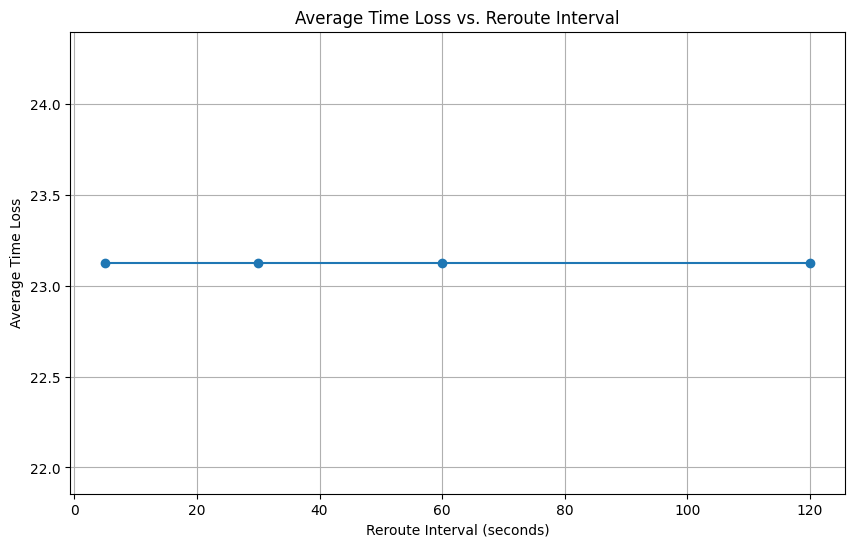

In [6]:


plt.figure(figsize=(10, 6))
plt.plot(df['Reroute Interval'], df['Average Time Loss'], marker='o')
plt.title('Average Time Loss vs. Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Average Time Loss')
plt.grid(True)
plt.show()


In [7]:
# Display descriptive statistics
df.describe()

,Total Vehicles,Total Time Loss,Average Time Loss,Total Waiting Time,Average Waiting Time,Average Duration,Total Reroutes,Average Reroutes,Reroute Interval
count,4.0,4.00,4.00000,4.0,4.000000,4.000000,4.0,4.000000,4.000000
mean,3452.0,79836.51,23.12761,8731.0,2.529258,143.711182,3426.0,0.992468,53.750000
std,0.0,0.00,0.00000,0.0,0.000000,0.000000,0.0,0.000000,49.560569
min,3452.0,79836.51,23.12761,8731.0,2.529258,143.711182,3426.0,0.992468,5.000000
25%,3452.0,79836.51,23.12761,8731.0,2.529258,143.711182,3426.0,0.992468,23.750000
50%,3452.0,79836.51,23.12761,8731.0,2.529258,143.711182,3426.0,0.992468,45.000000
75%,3452.0,79836.51,23.12761,8731.0,2.529258,143.711182,3426.0,0.992468,75.000000
max,3452.0,79836.51,23.12761,8731.0,2.529258,143.711182,3426.0,0.992468,120.000000


In [8]:
# Specific statistics for each reroute interval
grouped_stats = df.groupby('Reroute Interval').agg(['mean', 'std', 'min', 'max'])
grouped_stats

Total Vehicles                 Total Time Loss                \
                           mean std   min   max            mean std       min   
Reroute Interval                                                                
5                        3452.0 NaN  3452  3452        79836.51 NaN  79836.51   
30                       3452.0 NaN  3452  3452        79836.51 NaN  79836.51   
60                       3452.0 NaN  3452  3452        79836.51 NaN  79836.51   
120                      3452.0 NaN  3452  3452        79836.51 NaN  79836.51   

                           Average Time Loss      ... Average Duration  \
                       max              mean std  ...              min   
Reroute Interval                                  ...                    
5                 79836.51          23.12761 NaN  ...       143.711182   
30                79836.51          23.12761 NaN  ...       143.711182   
60                79836.51          23.12761 NaN  ...       143.711182   
120               79836.51          23.12761 NaN  ...       143.711182   

                             Total Reroutes                 Average Reroutes  \
                         max           mean std   min   max             mean   
Reroute Interval                                                               
5                 143.711182         3426.0 NaN  3426  3426         0.992468   
30                143.711182         3426.0 NaN  3426  3426         0.992468   
60                143.711182         3426.0 NaN  3426  3426         0.992468   
120               143.711182         3426.0 NaN  3426  3426         0.992468   

                                          
                 std       min       max  
Reroute Interval                          
5                NaN  0.992468  0.992468  
30               NaN  0.992468  0.992468  
60               NaN  0.992468  0.992468  
120              NaN  0.992468  0.992468  

[4 rows x 32 columns]

In [9]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Display correlation matrix
correlation_matrix

,Total Vehicles,Total Time Loss,Average Time Loss,Total Waiting Time,Average Waiting Time,Average Duration,Total Reroutes,Average Reroutes,Reroute Interval
Total Vehicles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Time Loss,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average Time Loss,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Waiting Time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average Waiting Time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average Duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Reroutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average Reroutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reroute Interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


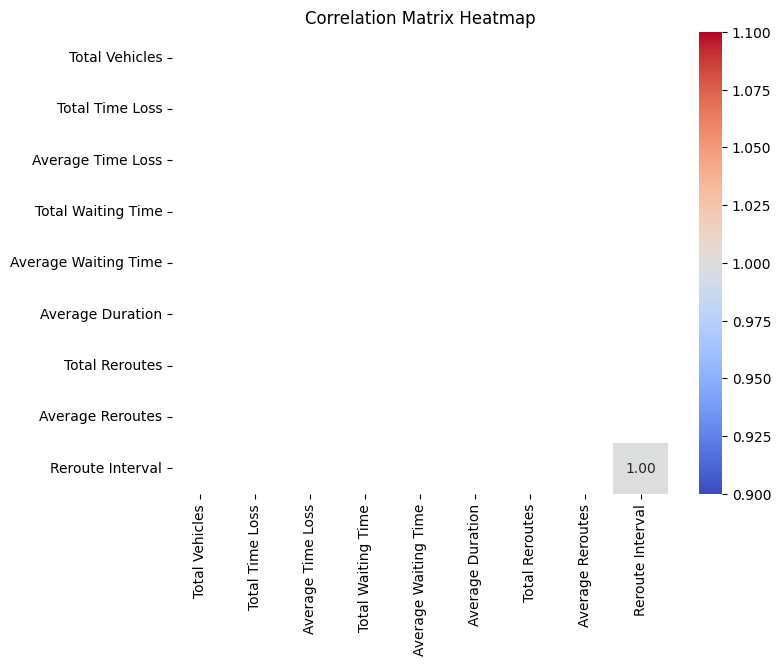

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


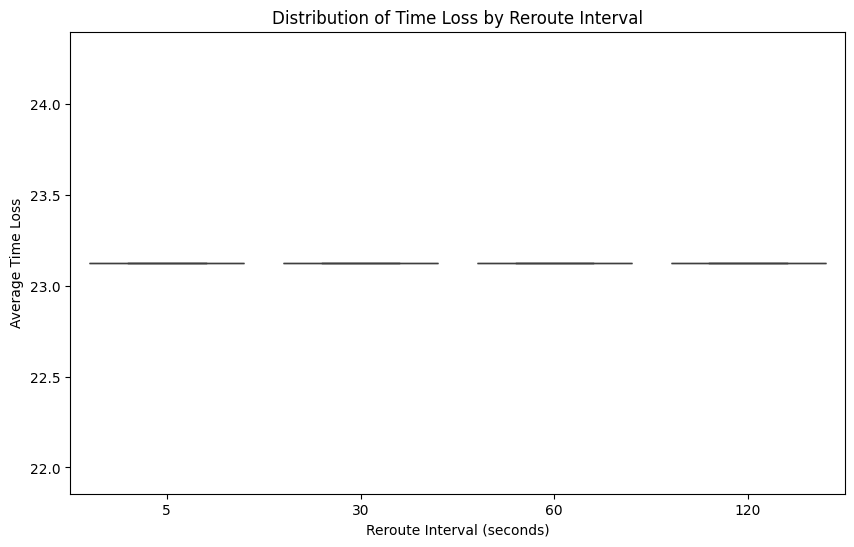

In [11]:


plt.figure(figsize=(10, 6))
sns.boxplot(x='Reroute Interval', y='Average Time Loss', data=df)
plt.title('Distribution of Time Loss by Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Average Time Loss')
plt.show()


In [12]:
# Add a constant term for the intercept in the regression model
X = sm.add_constant(df['Reroute Interval'])
y = df['Average Time Loss']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression analysis
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      Average Time Loss   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -2.000
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               1.00
Time:                        22:35:19   Log-Likelihood:                 126.96
No. Observations:                   4   AIC:                            -249.9
Df Residuals:                       2   BIC:                            -251.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               23.1276    4.5e-15  

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


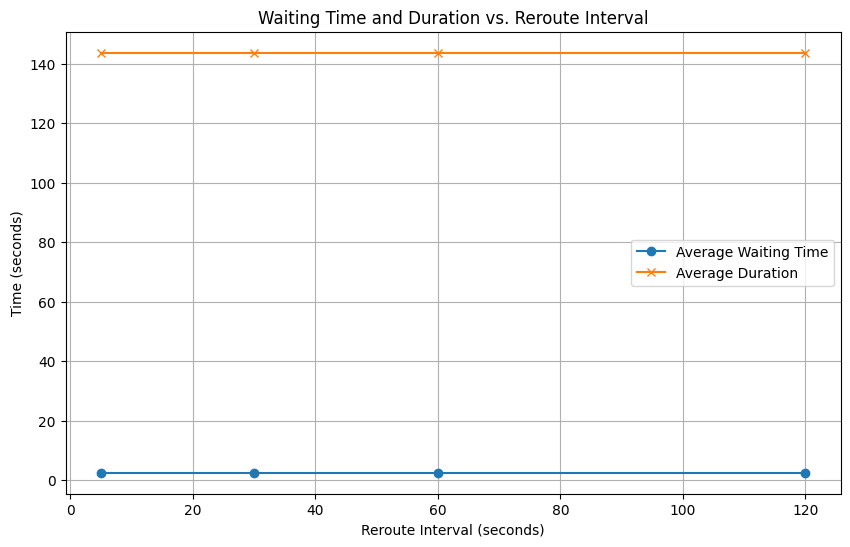

In [13]:
# Plot waiting time vs reroute interval
plt.figure(figsize=(10, 6))
plt.plot(df['Reroute Interval'], df['Average Waiting Time'], marker='o', label='Average Waiting Time')
plt.plot(df['Reroute Interval'], df['Average Duration'], marker='x', label='Average Duration')
plt.title('Waiting Time and Duration vs. Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()


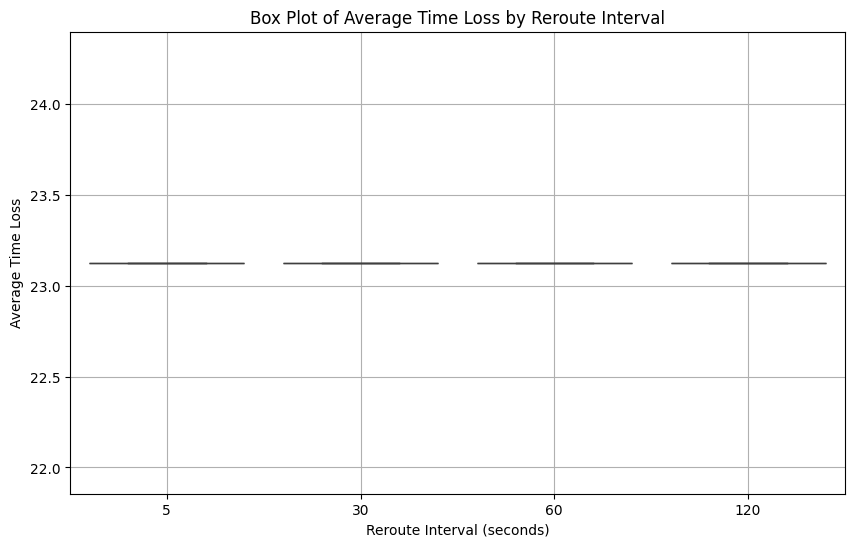

In [14]:
# Create a box plot for Average Time Loss vs. Reroute Interval
plt.figure(figsize=(10, 6))
sns.boxplot(x='Reroute Interval', y='Average Time Loss', data=df)
plt.title('Box Plot of Average Time Loss by Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Average Time Loss')
plt.grid(True)

# Show the plot
plt.show()

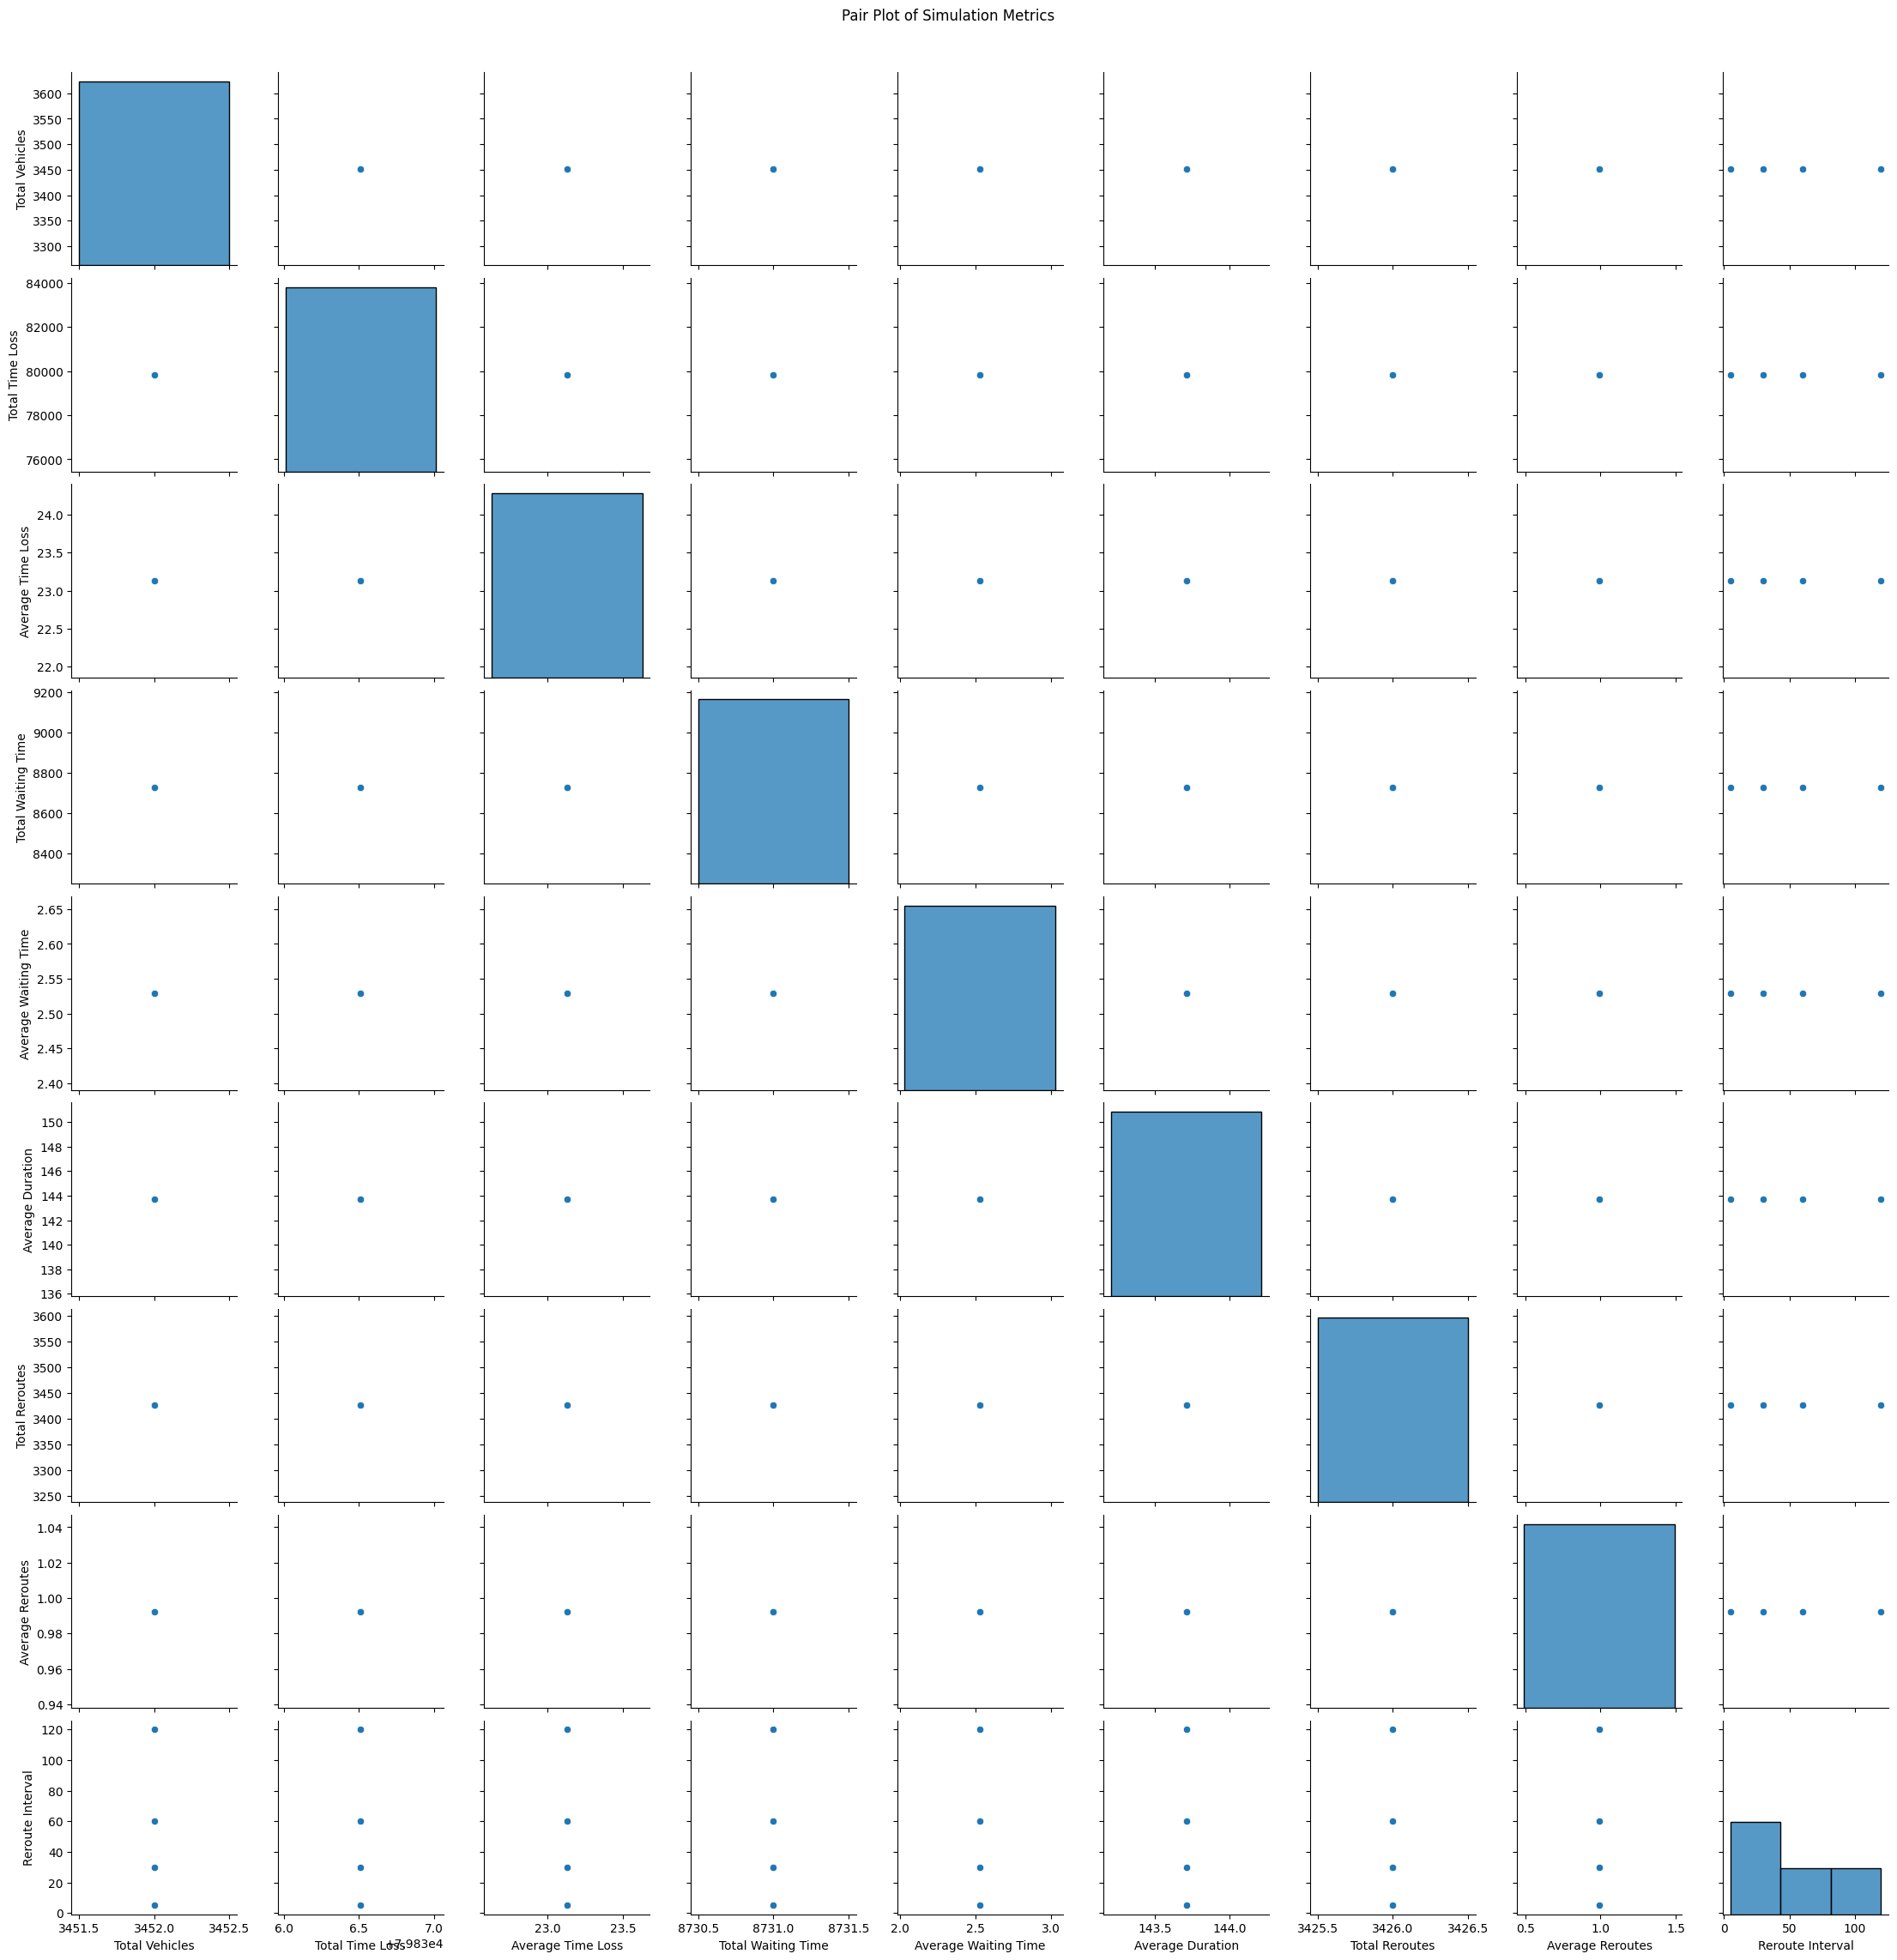

In [15]:
sns.pairplot(df)
plt.suptitle('Pair Plot of Simulation Metrics', y=1.02)
plt.show()